In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import train_test_split
from keras import regularizers


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, GlobalMaxPooling1D
from keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy


In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
data = pd.read_csv(r'/content/gdrive/MyDrive/ArSAS..txt',delimiter='\t')
data.head(3)

,#Tweet_ID,Tweet_text,Topic,Sentiment_label,Sentiment_label_confidence,Speech_act_label,Speech_act_label_confidence
0,929241870508724224,المباراة القـادمة #غانا x #مصر الجولة الأخيرة ...,Event,Positive,0.38,Assertion,0.62
1,928942264583376897,هل هذه هي سياسة خارجيه لدوله تحترم نفسها والآخ...,Entity,Negative,1.00,Expression,0.68
2,928615163250520065,وزير خارجية فرنسا عن منتدى شباب العالم: شعرت ب...,Event,Positive,0.69,Assertion,1.00
3,931614713368186880,ومع السيسي و بشار و ايران و بن زايد و والا خلي...,Event,Negative,1.00,Expression,1.00
4,929755693011427331,أهداف مباراة غانا 0 مصر 1 تصفيات كأس العالم 20...,Event,Neutral,1.00,Assertion,1.00
...,...,...,...,...,...,...,...
19892,929109605267000960,ملخص مباراة نيجيريا vs الجزائر تصفيات كأس 🏆 ال...,Event,Neutral,1.00,Assertion,1.00
19893,930131859039837952,ايطاليا في السان سيرو لعبت 42 مباراة 🇮🇹 31 فوز...,Event,Positive,0.69,Expression,0.69
19894,928739551136361984,المُلحق المؤهل لكأس العالم 🇪🇺أوروبا🇪🇺 مباراة ا...,Event,Neutral,1.00,Assertion,1.00
19895,929254320754823168,رسائل وتوصيات منتدى شباب العالم .. د. عبدالله ...,Event,Neutral,1.00,Assertion,1.00


In [ ]:
print("On a  {} doublons dans Data.".format(data.duplicated().sum()))

data.drop_duplicates(inplace = True)

print("On a  {} doublons dans Data.".format(data.duplicated().sum()))

On a  26 doublons dans Data.
On a  0 doublons dans Data.


In [ ]:
def preprocessing(x):
    x = re.sub('@[^\s]+', ' ', x)
    x = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',x)

    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030""]+", flags=re.UNICODE)
    emoji_pattern.sub(r'', x)

    ar_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ#'''
    en_punctuations = string.punctuation
    punctuations = ar_punctuations + en_punctuations
    x = x.translate(str.maketrans('', '', punctuations))

    arabic_diacritics = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    x = re.sub(arabic_diacritics, '', str(x)) 

#     x = re.sub("[إأآا]", "ا", x)
#     x = re.sub("ى", "ي", x)
#     x = re.sub("ة", "ه", x)
#     x = re.sub("گ", "ك", x)
#     x = re.sub(r'(.)\1+', r'\1', x)

    return x


In [ ]:
data["Clean_tweets"] = data.Tweet_text.apply(lambda x: preprocessing(str(x)))

In [ ]:
data["Topics"] = data['Topic'].astype("category").cat.codes

In [ ]:
data["Topics"]

0        1
1        0
2        1
3        1
4        1
        ..
19892    1
19893    1
19894    1
19895    1
19896    2
Name: Topics, Length: 19871, dtype: int8

In [ ]:
K = data["Topics"].max() + 1
K

3

In [ ]:
X = data.Clean_tweets
y = data.Topics

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.20, 
                                                    random_state = 42)

"""**printing the number of the train set and the test set**"""

print('Train set', X_train.shape)
print('Test set', X_test.shape)


Train set (15896,)
Test set (3975,)


In [ ]:
MAX_VOCAB_SIZE=250000
tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(X_train)


In [ ]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
MAX_SEQUENCE_LENGTH = 3456
# 
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                         maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                        maxlen = MAX_SEQUENCE_LENGTH)
# 

In [ ]:
import gensim
from gensim.models import KeyedVectors
import itertools
from numpy import loadtxt
from keras.models import load_model

In [ ]:
#target_word_vec = gensim.models.KeyedVectors.load_word2vec_format("/content/gdrive/MyDrive/cbow_100.bin", binary = True,unicode_errors='ignore')

target_word_vec = KeyedVectors.load_word2vec_format("/content/gdrive/MyDrive/cc.ar.300.vec", binary = False)

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
# 
for word, i in word_index.items():
     if word in target_word_vec :
         embedding_vector = target_word_vec[word]
         if embedding_vector is not None:
             embedding_matrix[i] = embedding_vector

embedding_matrix.shape[0] == vocab_size

True

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 
                            300, 
                            weights = [embedding_matrix], 
                            input_length = MAX_SEQUENCE_LENGTH, 
                            trainable=False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(64, dropout=0.2, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(K, activation='sigmoid'))

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.001), 
             loss=SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])

In [ ]:
r = model.fit(
  X_train,
  y_train,
  batch_size = 64,
  epochs=20,
  validation_data=(X_test, y_test)
)

Epoch 1/20
249/249 [==============================] - 80s 281ms/step - loss: 0.4816 - accuracy: 0.8043 - val_loss: 0.2587 - val_accuracy: 0.9031
Epoch 2/20
249/249 [==============================] - 70s 280ms/step - loss: 0.2412 - accuracy: 0.9099 - val_loss: 0.2175 - val_accuracy: 0.9182
Epoch 3/20
249/249 [==============================] - 71s 285ms/step - loss: 0.2053 - accuracy: 0.9244 - val_loss: 0.2008 - val_accuracy: 0.9235
Epoch 4/20
249/249 [==============================] - 71s 285ms/step - loss: 0.1874 - accuracy: 0.9306 - val_loss: 0.1889 - val_accuracy: 0.9296
Epoch 5/20
249/249 [==============================] - 71s 285ms/step - loss: 0.1736 - accuracy: 0.9349 - val_loss: 0.1792 - val_accuracy: 0.9343
Epoch 6/20
249/249 [==============================] - 71s 285ms/step - loss: 0.1619 - accuracy: 0.9400 - val_loss: 0.1715 - val_accuracy: 0.9369
Epoch 7/20
249/249 [==============================] - 74s 297ms/step - loss: 0.1510 - accuracy: 0.9434 - val_loss: 0.1685 - val_ac

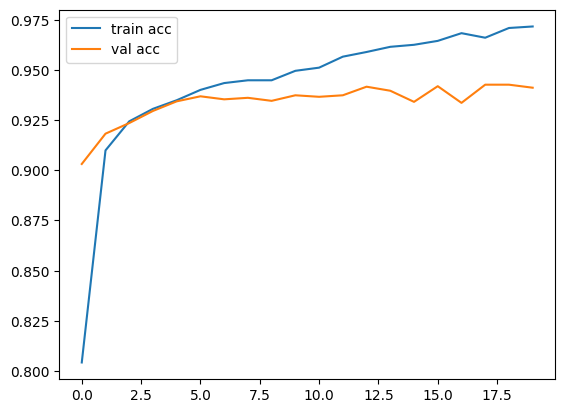

In [ ]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();